## making a butterfly diagram with python + d3

In this notebook, we will make a butterfly, or time-latitude, diagram. A butterfly diagram illustrates the sizes and positions of solar active regions and charts their characteristic march toward lower latitudes over the course of a solar cycle. To do this, we'll query the NASA Solar Dynamics Observatory database using a JSON API and then use `mpld3`, a python library that generates javascript internally.

In [1]:
import json, urllib, numpy as np, matplotlib.pylab as plt, matplotlib.ticker as mtick, mpld3
from mpld3 import plugins
from datetime import datetime as dt_obj
import matplotlib.dates as mdates
import matplotlib.colors as mcol
from matplotlib.dates import *
from astropy.io import fits
import math
%matplotlib inline
%config InlineBackend.figure_format='retina'
mpld3.enable_notebook()

Now we'll execute a JSON query using the `json` and `urllib` modules to find the location of the FITS data segments:

In [2]:
# first get the most recent timestamp, or t_rec
url = "http://jsoc.stanford.edu/cgi-bin/ajax/jsoc_info?ds=hmi.meanpf_720s[$]&op=rs_list&key=T_REC"
response = urllib.urlopen(url)
data = json.loads(response.read())
t_last = data['keywords'][0]['values'][0]

url = "http://jsoc.stanford.edu/cgi-bin/ajax/jsoc_info?ds=hmi.meanpf_720s[2010.05.01_00_TAI-"+t_last+"@1d]&op=rs_list&seg=mf_br"
response = urllib.urlopen(url)
data = json.loads(response.read())
filename = data['segments'][0]['values']
n_elements = len(filename)
print "There are "+str(n_elements)+" files."

There are 1942 files.


And get the corresponding times:

In [3]:
url = "http://jsoc.stanford.edu/cgi-bin/ajax/jsoc_info?ds=hmi.meanpf_720s[2010.05.01_00_TAI-"+t_last+"@1d]&op=rs_list&key=T_REC"
response = urllib.urlopen(url)
data = json.loads(response.read())
t_rec = data['keywords'][0]['values'][0]

We'll populate our lists to hold the time keyword, t_rec, values:

In [4]:
t_rec  = [] # this holds the keyword T_REC
for i in range(n_elements):
    t_rec.append(data['keywords'][0]['values'][i])

Convert t_rec into a datetime object, and from a datetime object into a floating point number so that `matplotlib` will be able to interpret it:

In [5]:
# format t_rec as a numpy array
t_rec  = np.array(t_rec,dtype='S16') # this dtype is ok to set as the format of T_REC will never change

# convert t_rec into a datetime object 
def parse_tai_string(tstr,datetime=True):
    year   = int(tstr[:4])
    month  = int(tstr[5:7])
    day    = int(tstr[8:10])
    hour   = int(tstr[11:13])
    minute = int(tstr[14:16])
    if datetime: return dt_obj(year,month,day,hour,minute)
    else: return year,month,day,hour,minute
x = np.array([parse_tai_string(t_rec[i],datetime=True) for i in range(t_rec.size)])

# convert the datetime object into a floating point number
xmdates = mdates.date2num(x)

Now we'll use the `astropy` library to open the FITS data:

In [6]:
mf_br = np.ndarray([180,n_elements])
for i in range(len(filename)):
    url = "http://jsoc.stanford.edu"+filename[i]
    hdu = fits.open(url)
    mf_br[:,i] = hdu[0].data

The function below returns the differential rotation period for any given latitude in units of days:

In [7]:
def differential_rotation_period(latitude):
    k = 3.6e3*24.*1e-6*(180./math.pi)
    a = 2.7139*k
    b = -0.405*k
    c = -0.422*k
    theta = (90. - latitude)*(math.pi/180.)
    cos_theta = math.cos(theta) 
    omega = a + b*cos_theta*cos_theta + c*cos_theta*cos_theta*cos_theta*cos_theta
    period = 360./omega
    return period

Smooth the data by computing a running average; the window of the average is the period at that latitude.

In [8]:
mf_br_averaged = np.ndarray([180,n_elements])
for j in range(n_elements):
    for i in range(180):
        latitude = i-90.
        period = differential_rotation_period(latitude)
        period_even = math.ceil(period/2.)*2 # round the period to the nearest even number
        half_period_even = int(math.ceil(period/2.)*2)/2
        value = np.sum(mf_br[i,j-half_period_even:j+half_period_even])
        mf_br_averaged[i,j] = value/period_even

And create the butterfly diagram:

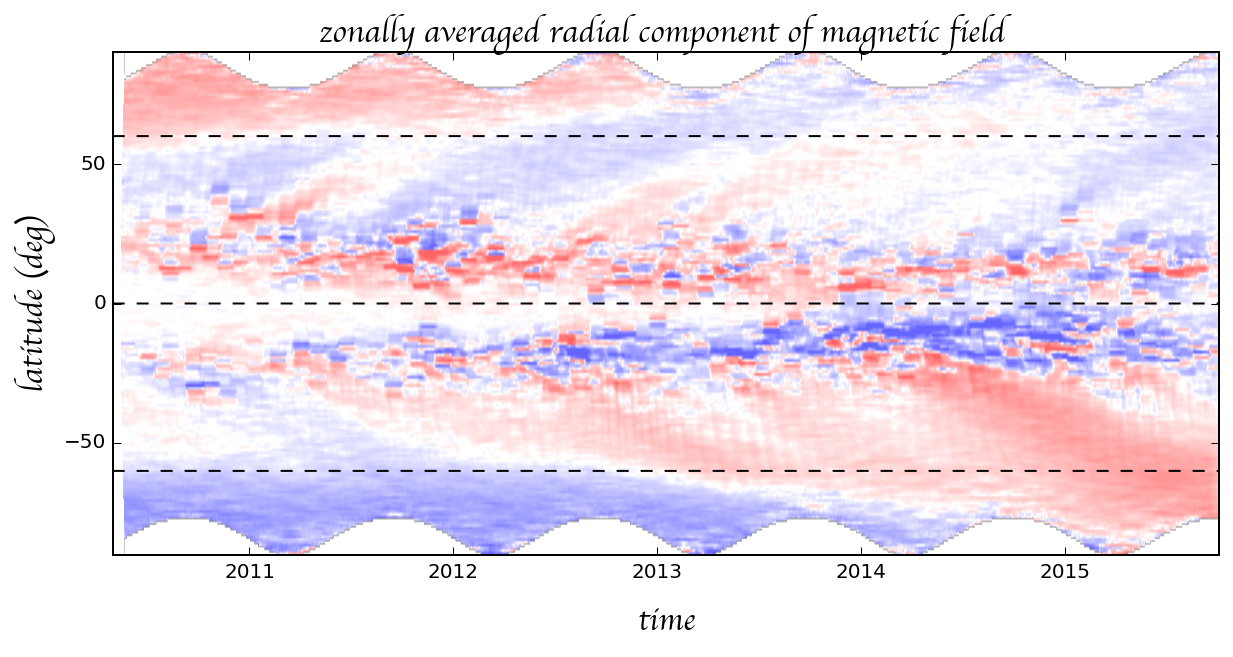

In [9]:
# create the figure
fig, ax = plt.subplots(1,1)

# define some style elements
marker_style = dict(linestyle='-', linewidth=4, fillstyle='full')
text_style = {'family':'cursive','color':'black','weight':'normal','size': 16}

# plot some reference latitudes
zero_lat = np.zeros([n_elements])
mi60_lat = np.ndarray([n_elements])
pl60_lat = np.ndarray([n_elements])
mi60_lat.fill(-60)
pl60_lat.fill(60)
plt.plot(xmdates,zero_lat,'--',color='black')
plt.plot(xmdates,mi60_lat,'--',color='black')
plt.plot(xmdates,pl60_lat,'--',color='black')

# plot the image with a customized color table
colors = np.loadtxt('cstretch.txt')
colormap_customized = mcol.ListedColormap(colors)
im = plt.imshow(mf_br_averaged,cmap=colormap_customized,vmax=8,vmin=-8,extent=[xmdates[0],xmdates[n_elements-1],-90,90],origin='lower')

# format the x-axis with universal time
ax.xaxis_date()
locator = AutoDateLocator()
locator.intervald[MONTHLY] = [8]
formatter = DateFormatter('%Y')
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

# label the axes and the plot
ax.set_xlabel('time', labelpad=10, fontdict = text_style)
ax.set_ylabel('latitude (deg)', fontdict=text_style)
ax.set_title('zonally averaged radial component of magnetic field', fontdict = text_style)
ax.set_aspect(5)
fig.set_size_inches(10,4.5)

In [10]:
mpld3.save_html(fig,'butterfly.html')